# Cycling data from Auckland New Zeeland


You receive hourly data from the city of Auckland. They wanted to promote cycling in the city and decided to monitor cyclists to see how many cyclists travel through the city.

Your assignment is to make a forecasting model for the year 2018 (daily counts). Quantify the performance and see if you can improve your model by adding holidays and or weather.

I have aggregated the data for you in nice files so that you do not have to to the messy work.


daily counts: cycling_counts_by_day.csv
hourly counts: cycling_counts_combined_2014_2018.csv
auckland weather: Auckland_weather_combined.csv

for holidays you can use the holidays python package

In [34]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
import holidays

import matplotlib.pyplot as plt

### Read data

In [35]:
cycle_data = pd.read_csv("cycling_counts_by_day.csv",)
cycle_data.rename(columns={'Tamaki Drive EB':"amount"},inplace = True)
cycle_data['datetime']= pd.to_datetime(cycle_data['datetime'])
cycle_data.head()


,datetime,amount
0,2010-07-01,570.0
1,2010-07-02,473.0
2,2010-07-03,766.0
3,2010-07-04,240.0
4,2010-07-05,172.0


In [36]:
cycle_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2892 entries, 0 to 2891
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2892 non-null   datetime64[ns]
 1   amount    2892 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 45.3 KB


In [37]:
cycle_data.describe()

,datetime,amount
count,2892,2892.000000
mean,2014-06-15 12:00:00,679.146957
min,2010-07-01 00:00:00,23.000000
25%,2012-06-22 18:00:00,505.750000
50%,2014-06-15 12:00:00,676.000000
75%,2016-06-07 06:00:00,839.000000
max,2018-05-31 00:00:00,1832.000000
std,NaN,238.966371


<Axes: xlabel='datetime', ylabel='amount'>

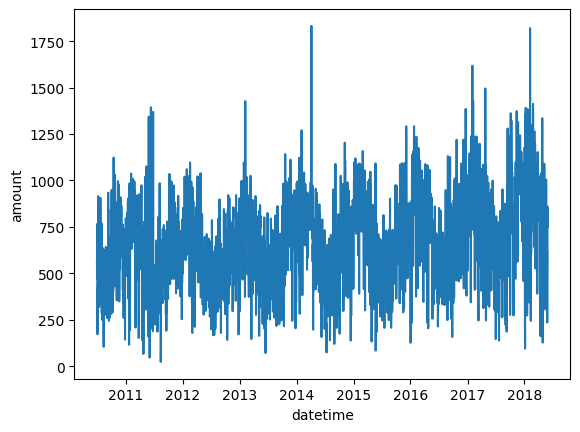

In [38]:
sns.lineplot(cycle_data, x = 'datetime', y = 'amount', legend = False)


In [39]:

train_cycle = cycle_data[cycle_data['datetime']<'2018']
test_cycle = cycle_data[cycle_data['datetime']>='2018']

train_cycle.tail()


,datetime,amount
2736,2017-12-27,838.0
2737,2017-12-28,940.0
2738,2017-12-29,811.0
2739,2017-12-30,960.0
2740,2017-12-31,914.0


In [40]:
future_days = len(test_cycle)
future_days

151

In [41]:
test_cycle.head()

,datetime,amount
2741,2018-01-01,522.0
2742,2018-01-02,1179.0
2743,2018-01-03,1000.0
2744,2018-01-04,231.0
2745,2018-01-05,95.0


In [42]:

nz_holidays = holidays.NewZealand(years=range(2010,2019),subdiv='Auckland')  
all_holidays = pd.DataFrame(
    [{"ds": date, "holiday": name} for date, name in nz_holidays.items()])
all_holidays.sort_values(by="ds")

,ds,holiday
37,2010-01-01,New Year's Day
38,2010-01-02,Day after New Year's Day
39,2010-01-04,Day after New Year's Day (observed)
50,2010-02-01,Auckland Anniversary Day
40,2010-02-06,Waitangi Day
...,...,...
29,2018-04-25,Anzac Day
32,2018-06-04,Queen's Birthday
33,2018-10-22,Labour Day
34,2018-12-25,Christmas Day


In [43]:
weather = pd.read_csv('Auckland_weather_combined.csv',sep=";")
weather

,day,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571
...,...,...,...,...,...
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714
2342,2018-05-31,1.483571,2.057143,0.000000,8.957143


In [44]:
weather[['sun', 'wind', 'rain', 'temp']] = weather[['sun', 'wind', 'rain', 'temp']].fillna(method='ffill').fillna(method='bfill')

weather.rename(columns={'day':"datetime"},inplace = True)
weather['datetime']= pd.to_datetime(weather['datetime'])
weather

/tmp/ipykernel_16999/1550118913.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  weather[['sun', 'wind', 'rain', 'temp']] = weather[['sun', 'wind', 'rain', 'temp']].fillna(method='ffill').fillna(method='bfill')


,datetime,sun,wind,rain,temp
0,2012-01-01,0.161071,5.578571,0.000000,20.250000
1,2012-01-02,0.295238,10.820000,0.000000,18.400000
2,2012-01-03,0.588095,5.171429,0.028571,19.814286
3,2012-01-04,0.325238,3.778571,0.402381,19.857143
4,2012-01-05,0.595238,3.257143,0.079286,20.478571
...,...,...,...,...,...
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714
2342,2018-05-31,1.483571,2.057143,0.000000,8.957143


In [45]:
merged_df = pd.merge(weather, cycle_data, on='datetime', how='inner')
                     
merged_df

,datetime,sun,wind,rain,temp,amount
0,2012-01-01,0.161071,5.578571,0.000000,20.250000,792.0
1,2012-01-02,0.295238,10.820000,0.000000,18.400000,500.0
2,2012-01-03,0.588095,5.171429,0.028571,19.814286,711.0
3,2012-01-04,0.325238,3.778571,0.402381,19.857143,852.0
4,2012-01-05,0.595238,3.257143,0.079286,20.478571,820.0
...,...,...,...,...,...,...
2338,2018-05-27,0.272143,8.600000,1.404524,12.878571,235.0
2339,2018-05-28,0.604762,3.200000,0.000000,9.200000,709.0
2340,2018-05-29,1.459762,2.571429,0.000000,8.385714,859.0
2341,2018-05-30,1.359762,2.587500,0.000000,8.335714,787.0


In [46]:
train_cycle = merged_df[merged_df['datetime']<'2018']
test_cycle = merged_df[merged_df['datetime']>='2018']

train_cycle.rename(columns={'datetime':"ds"},inplace = True);
train_cycle.rename(columns={'amount':"y"},inplace = True);
test_cycle.rename(columns={'datetime':"ds"},inplace = True);
test_cycle.rename(columns={'amount':"y"},inplace = True);

train_cycle

/tmp/ipykernel_16999/1147240417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cycle.rename(columns={'datetime':"ds"},inplace = True);
/tmp/ipykernel_16999/1147240417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_cycle.rename(columns={'amount':"y"},inplace = True);
/tmp/ipykernel_16999/1147240417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cycle.rename(columns={'datetime':"ds"},inplace = True);
/tmp/

,ds,sun,wind,rain,temp,y
0,2012-01-01,0.161071,5.578571,0.000000,20.250000,792.0
1,2012-01-02,0.295238,10.820000,0.000000,18.400000,500.0
2,2012-01-03,0.588095,5.171429,0.028571,19.814286,711.0
3,2012-01-04,0.325238,3.778571,0.402381,19.857143,852.0
4,2012-01-05,0.595238,3.257143,0.079286,20.478571,820.0
...,...,...,...,...,...,...
2187,2017-12-27,2.047500,6.604167,0.000000,20.564286,838.0
2188,2017-12-28,1.531429,7.821429,0.000000,18.200000,940.0
2189,2017-12-29,2.403571,7.062500,0.000000,19.657143,811.0
2190,2017-12-30,2.459048,5.521429,0.000000,21.478571,960.0


In [47]:
train_cycle = train_cycle[train_cycle['ds'] > '2014']
train_cycle

,ds,sun,wind,rain,temp,y
732,2014-01-02,2.566071,5.058333,0.000000,21.107143,985.0
733,2014-01-03,1.521667,7.114286,0.000000,22.278571,667.0
734,2014-01-04,0.576905,5.607143,0.039643,24.085714,709.0
735,2014-01-05,0.302381,7.114286,0.192857,21.535714,563.0
736,2014-01-06,2.342500,6.757143,0.000000,20.157143,926.0
...,...,...,...,...,...,...
2187,2017-12-27,2.047500,6.604167,0.000000,20.564286,838.0
2188,2017-12-28,1.531429,7.821429,0.000000,18.200000,940.0
2189,2017-12-29,2.403571,7.062500,0.000000,19.657143,811.0
2190,2017-12-30,2.459048,5.521429,0.000000,21.478571,960.0


In [48]:
m = Prophet(holidays=all_holidays,
            seasonality_mode='multiplicative')
m.add_regressor('sun')
m.add_regressor('rain')
m.add_regressor('wind')
m.add_regressor('temp')

m.fit(train_cycle)

14:04:59 - cmdstanpy - INFO - Chain [1] start processing
14:04:59 - cmdstanpy - INFO - Chain [1] done processing


In [49]:
forecast_days = future_days

future = m.make_future_dataframe(periods=forecast_days )

future = pd.merge(future,test_cycle,on='ds',how='inner')
print(future)

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast.loc[forecast['yhat'] <0, 'yhat'] = 0

            ds       sun       wind      rain       temp       y
0   2018-01-01  0.054762   3.721429  0.476190  21.642857   522.0
1   2018-01-02  1.886429   3.635714  0.000000  23.485714  1179.0
2   2018-01-03  1.601429   3.866667  0.035714  23.171429  1000.0
3   2018-01-04  0.000000   6.092857  4.983095  21.520000   231.0
4   2018-01-05  0.000000  10.100000  2.285119  19.575000    95.0
..         ...       ...        ...       ...        ...     ...
146 2018-05-27  0.272143   8.600000  1.404524  12.878571   235.0
147 2018-05-28  0.604762   3.200000  0.000000   9.200000   709.0
148 2018-05-29  1.459762   2.571429  0.000000   8.385714   859.0
149 2018-05-30  1.359762   2.587500  0.000000   8.335714   787.0
150 2018-05-31  1.483571   2.057143  0.000000   8.957143   749.0

[151 rows x 6 columns]


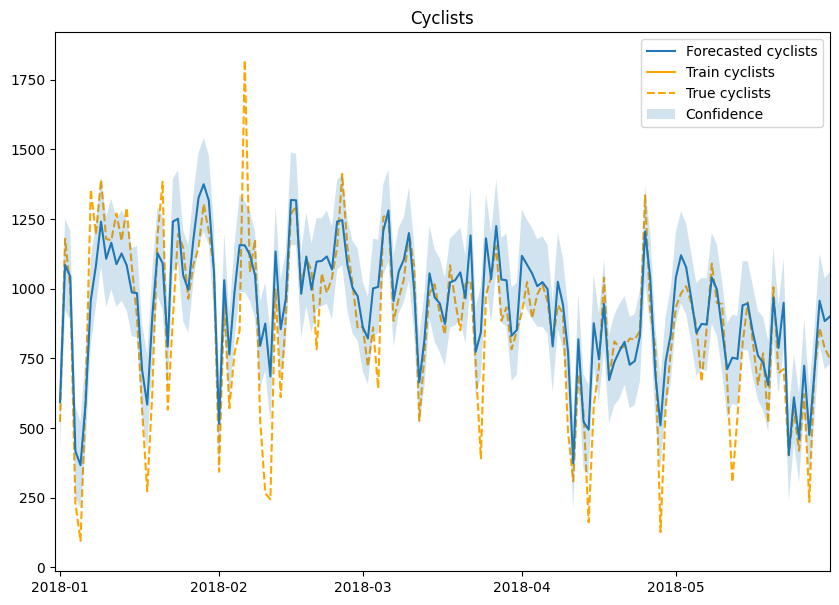

In [50]:
train_data_plot = train_cycle
test_data_plot = test_cycle

plt.figure(figsize = (10,7))
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted cyclists', zorder = 1)
plt.plot(train_data_plot['ds'], train_data_plot['y'], label='Train cyclists', zorder = 0, color = 'orange')                                                                                       
plt.plot(test_data_plot['ds'], test_data_plot['y'], label='True cyclists', zorder = 0, color = 'orange', linestyle='dashed')
plt.fill_between(forecast['ds'], forecast['yhat_upper'], forecast['yhat_lower'],
                 alpha=.2, label='Confidence')
plt.title('Cyclists')
plt.legend()
plt.xlim(pd.to_datetime(['2017-12-31','2018-05-31']))
#plt.savefig('prophet_forecast.png')
plt.show()